In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error, r2_score

In [8]:
df = pd.read_csv("/Users/hanzichun/desktop/Optiver-07/Data/individual_book_train/stock_0.csv")

In [9]:
df['mid_price'] = (df['bid_price1'] + df['ask_price1']) / 2
df['spread'] = df['ask_price1'] - df['bid_price1']
df['log_return'] = np.log(df['mid_price'] / df['mid_price'].shift(1)).fillna(0)

df['realized_volatility'] = (
    df['log_return']
    .rolling(window=30, min_periods=1)
    .apply(lambda x: np.sqrt(np.sum(x**2)))
)

df['rv_future'] = df['realized_volatility'].shift(-30)
df = df.dropna()

feature_cols = ['bid_price1', 'ask_price1', 'bid_price2', 'ask_price2',
                'mid_price', 'spread', 'log_return', 'realized_volatility']

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_all = x_scaler.fit_transform(df[feature_cols])
y_all = y_scaler.fit_transform(df[['rv_future']]).flatten()

SEQ_LEN = 30

def build_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i + seq_len])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = build_sequences(X_all, y_all, SEQ_LEN)

split_idx = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

In [10]:
def build_baseline_hav_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Simple CNN
    x = layers.Conv1D(16, kernel_size=3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)

    # Simple Transformer Attention
    attention_output = layers.MultiHeadAttention(
        num_heads=2, key_dim=x.shape[-1]
    )(x, x)
    x = layers.Add()([x, attention_output])
    x = layers.LayerNormalization()(x)

    x = layers.GlobalAveragePooling1D()(x)

    output = layers.Dense(1, activation='linear')(x)

    model = models.Model(inputs, output)
    return model

hav_baseline = build_baseline_hav_model((SEQ_LEN, X_train.shape[-1]))

hav_baseline.compile(
    optimizer='adam',
    loss='mse'
)

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = hav_baseline.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    shuffle=False,
    callbacks=[early_stop],
    verbose=1
)

y_pred_scaled = hav_baseline.predict(X_test).flatten()

y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

rmse = root_mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

def qlike_safe(actual, forecast, eps=1e-8):
    a = np.clip(actual, eps, None)
    f = np.clip(forecast, eps, None)
    r = a / f
    return np.mean(r - np.log(r) - 1.0)

ql = qlike_safe(y_true, y_pred)

print(f"Out-of-sample RMSE: {rmse:.6f}")
print(f"R² score: {r2:.6f}")
print(f"QLIKE: {ql:.6f}")

Epoch 1/50
18350/18350 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - loss: 0.0060 - val_loss: 8.7571e-04
Epoch 2/50
18350/18350 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - loss: 8.6150e-04 - val_loss: 8.1944e-04
Epoch 3/50
18350/18350 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - loss: 7.0127e-04 - val_loss: 7.7461e-04
Epoch 4/50
18350/18350 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - loss: 6.8667e-04 - val_loss: 7.7079e-04
Epoch 5/50
18350/18350 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - loss: 6.8070e-04 - val_loss: 7.7123e-04
Epoch 6/50
18350/18350 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - loss: 6.7338e-04 - val_loss: 7.7227e-04
Epoch 7/50
18350/18350 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - loss: 6.7181e-04 - val_loss: 7.6699e-04
Epoch 8/50
18350/18350 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - loss: 6.7043e-04 - val_loss: 7.8294e-04
Epoch 9/50
18350/18350 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - loss: 6.6765e-04 - val_loss: 7.6760e-04
Epoch 10/50
18350/18350 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - loss: 6.6423e-04 - val_loss: 7.5125e-04
Epoch 11/50
1

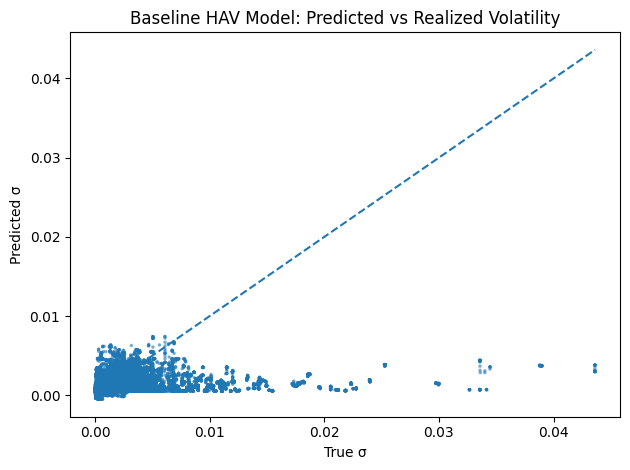

In [11]:
plt.figure()
plt.scatter(y_true, y_pred, s=6, alpha=0.6, edgecolor="none")
max_val = max(np.max(y_true), np.max(y_pred))
plt.plot([0, max_val], [0, max_val], linestyle="--")
plt.title("Baseline HAV Model: Predicted vs Realized Volatility")
plt.xlabel("True σ")
plt.ylabel("Predicted σ")
plt.tight_layout()
plt.show()

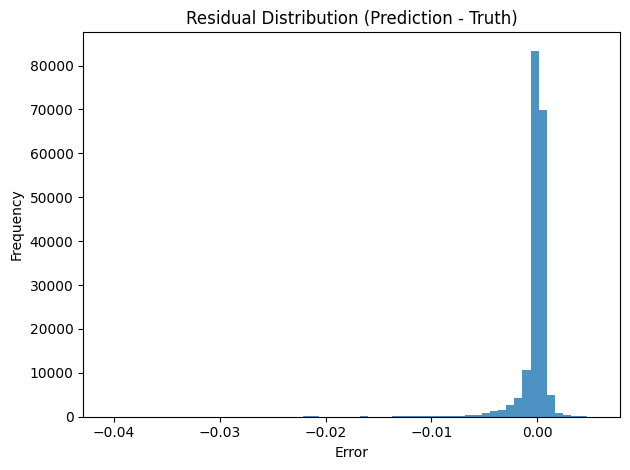

In [12]:
residuals = y_pred - y_true
plt.figure()
plt.hist(residuals, bins=60, alpha=0.8)
plt.title("Residual Distribution (Prediction - Truth)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

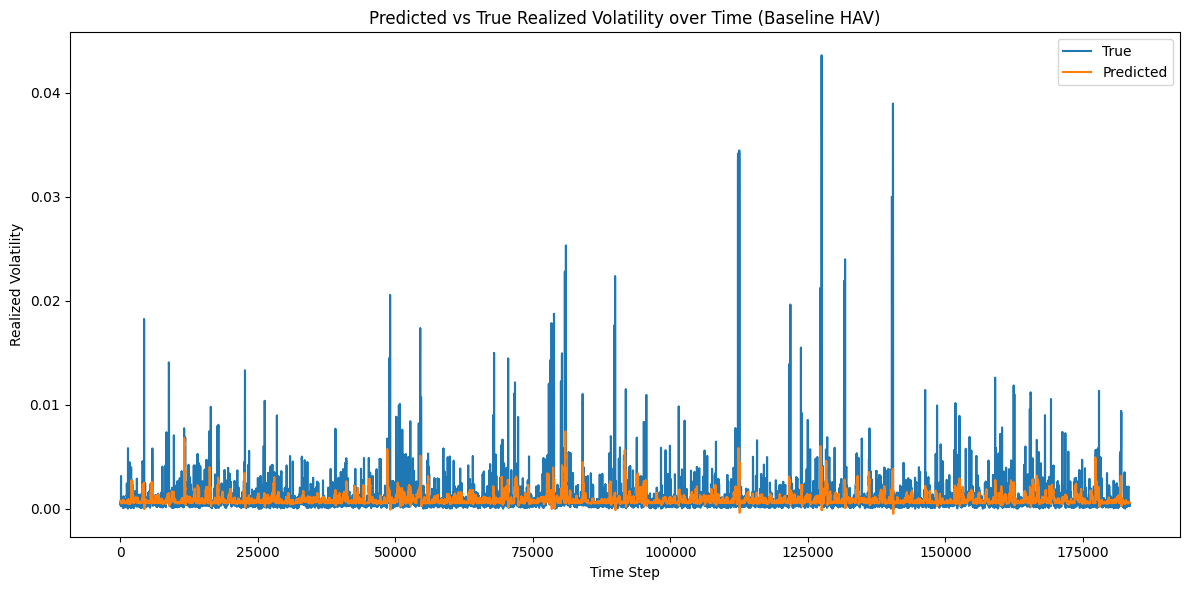

In [13]:
plt.figure(figsize=(12,6))
plt.plot(y_true, label='True')
plt.plot(y_pred, label='Predicted')
plt.title('Predicted vs True Realized Volatility over Time (Baseline HAV)')
plt.xlabel('Time Step')
plt.ylabel('Realized Volatility')
plt.legend()
plt.tight_layout()
plt.show()

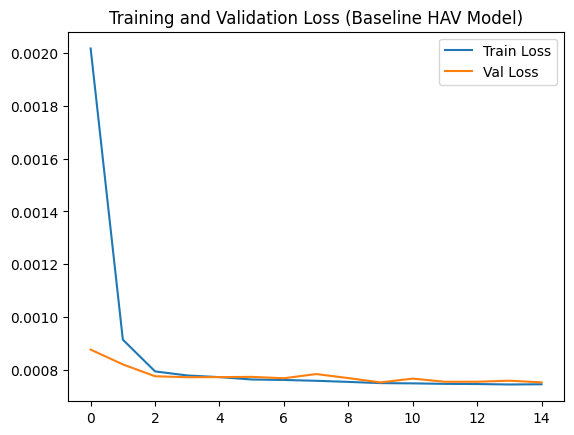

In [14]:
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training and Validation Loss (Baseline HAV Model)")
plt.legend()
plt.show()
